<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/daRunnareFrancy/ICaRLMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [1]:
import os
import logging
import sys

In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone -b daRunnareFrancy https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1569 (delta 38), reused 0 (delta 0), pack-reused 1499
Receiving objects: 100% (1569/1569), 1.18 MiB | 1.01 MiB/s, done.
Resolving deltas: 100% (1002/1002), done.


# Import packages

In [3]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from DatasetCIFAR import ICaRLModel
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Datasets

In [5]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [7]:
train_splits = trainDS.splits
test_splits = testDS.splits

# Define Network

In [8]:
ICaRL = ResNet.resnet32(num_classes=100)
ICaRL =  ICaRL.to(params.DEVICE)

In [9]:
exemplars = [None]*100

test_indexes =  []
accs = []

At step  0  and at epoch =  0  the loss is =  0.03283439204096794  and accuracy is =  0.157
At step  0  and at epoch =  1  the loss is =  0.02956738881766796  and accuracy is =  0.3686
At step  0  and at epoch =  2  the loss is =  0.026554249227046967  and accuracy is =  0.4502
Selected:  [9056, 20066, 32710, 30170, 48746, 43459, 4722, 1435, 40834, 28891, 49982, 9112, 20653, 25415, 30527, 39985, 31825, 112, 33875, 19873, 44482, 29884, 7189, 2589, 31910, 33445, 11738, 10644, 30585, 2309, 29636, 1189, 32696, 46354, 43391, 12820, 22226, 13250, 43975, 41060, 30934, 3005, 4370, 14488, 29644, 45652, 18682, 4988, 49815, 6536, 28706, 31897, 25448, 47196, 14250, 2486, 15797, 39092, 46032, 8992, 47857, 32537, 11436, 22009, 45955, 30557, 47476, 27790, 28764, 44593, 34451, 34541, 9304, 39327, 18914, 26306, 23646, 39530, 18345, 11579, 19237, 3559, 19361, 3177, 45510, 18924, 43548, 2298, 44720, 16182, 46875, 32473, 49818, 45494, 5888, 8631, 27975, 15927, 26932, 15538, 45575, 13826, 31313, 40319, 295

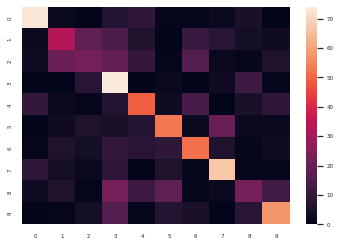

At step  10  and at epoch =  0  the loss is =  0.04500354453921318  and accuracy is =  0.14108416547788874
At step  10  and at epoch =  1  the loss is =  0.0383937731385231  and accuracy is =  0.3158345221112696
At step  10  and at epoch =  2  the loss is =  0.03661169484257698  and accuracy is =  0.38830242510699003
Selected:  [47878, 46305, 27262, 20256, 46517, 16199, 16762, 30456, 8660, 33529, 33990, 30695, 5589, 2956, 27913, 42382, 7073, 17794, 26939, 21083, 39234, 1225, 7412, 7915, 1120, 6284, 30478, 624, 39811, 23724, 41493, 28955, 895, 26327, 37974, 4616, 31044, 2992, 10673, 17614, 28636, 24722, 41441, 1245, 14896, 34470, 37234, 16742, 45997, 9591, 4138, 42388, 7963, 43445, 279, 3836, 25904, 37932, 37377, 30842, 2815, 2740, 36010, 9871, 17950, 27410, 44821, 18711, 48390, 41709, 34368, 32628, 23037, 8864, 4267, 15772, 41892, 29548, 17859, 24222, 30363, 1831, 22905, 32945, 43955, 20734, 44121, 19149, 38213, 19239, 24320, 43823, 21643, 15573, 12777, 18662, 14817, 2739, 45613, 19892

In [ ]:
for task in range(0, 100, params.TASK_SIZE):
  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, transform = train_transformer)
  test_dataset = Subset(testDS, test_indexes, transform = test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE , shuffle=True )
  
  ICaRL, exemplars = ICaRLModel.incrementalTrain(task, trainDS, ICaRL, exemplars, train_transformer)

  col = []
  for i,x in enumerate( train_splits[ :int(task/10) + 1]) : 
    v = np.array(x)
    col = np.concatenate( (col,v), axis = None)
    col = col.astype(int)
  mean = None
  total = 0.0
  running_corrects = 0.0
  for img, lbl, _ in train_loader:
      img = img.float().to(params.DEVICE)
      preds, mean = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'train accuracy = {accuracy}')
  accs.append(accuracy)

  total = 0.0
  running_corrects = 0.0
  tot_preds = []
  tot_lab = []
  for img, lbl, _ in test_loader:
      img = img.float().to(params.DEVICE)
      preds, _ = ICaRLModel.classify(img, exemplars, ICaRL, task, trainDS, mean)
      preds = preds.to(params.DEVICE)
      labels = utils.mapFunction(lbl, col).to(params.DEVICE)

      tot_preds = np.concatenate( ( tot_preds, preds.data.cpu().numpy() ) )
      tot_lab = np.concatenate( (tot_lab, labels.data.cpu().numpy()  ) )

      total += len(lbl)
      running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = float(running_corrects/total)
  print(f'task: {task}', f'test accuracy = {accuracy}')
  cf = confusion_matrix(tot_lab, tot_preds)
  df_cm = pd.DataFrame(cf, range(task + params.TASK_SIZE), range(task + params.TASK_SIZE))
  sn.set(font_scale = .5) # for label size
  sn.heatmap(df_cm, annot=False)
  plt.show()